In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin) / num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        # Grab random start point for each batch
        rand_start = np.random.rand(batch_size, 1)
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        # Create batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0, steps+1) * self.resolution
        
        # Create Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        # Formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

In [3]:
ts_data = TimeSeriesData(250,0,10)

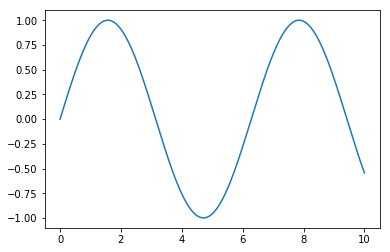

In [4]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [5]:
num_time_steps = 30

In [6]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

In [7]:
ts

array([[6.94436218, 6.98436218, 7.02436218, 7.06436218, 7.10436218,
        7.14436218, 7.18436218, 7.22436218, 7.26436218, 7.30436218,
        7.34436218, 7.38436218, 7.42436218, 7.46436218, 7.50436218,
        7.54436218, 7.58436218, 7.62436218, 7.66436218, 7.70436218,
        7.74436218, 7.78436218, 7.82436218, 7.86436218, 7.90436218,
        7.94436218, 7.98436218, 8.02436218, 8.06436218, 8.10436218,
        8.14436218]])

In [8]:
ts.shape

(1, 31)

In [9]:
ts.flatten()

array([6.94436218, 6.98436218, 7.02436218, 7.06436218, 7.10436218,
       7.14436218, 7.18436218, 7.22436218, 7.26436218, 7.30436218,
       7.34436218, 7.38436218, 7.42436218, 7.46436218, 7.50436218,
       7.54436218, 7.58436218, 7.62436218, 7.66436218, 7.70436218,
       7.74436218, 7.78436218, 7.82436218, 7.86436218, 7.90436218,
       7.94436218, 7.98436218, 8.02436218, 8.06436218, 8.10436218,
       8.14436218])

In [10]:
ts.flatten().shape

(31,)

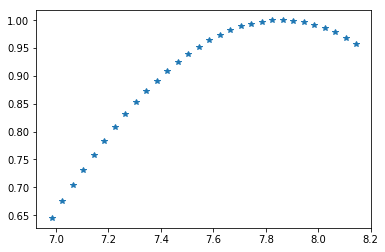

In [11]:
plt.plot(ts.flatten()[1:], y2.flatten(), "*")

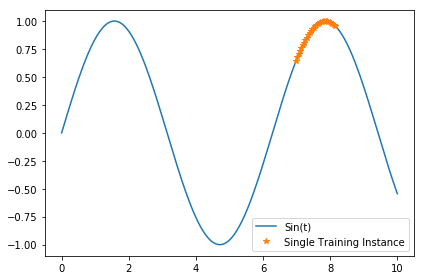

In [12]:
plt.plot(ts_data.x_data, ts_data.y_true, label="Sin(t)")
plt.plot(ts.flatten()[1:], y2.flatten(), "*", label = "Single Training Instance")
plt.legend()
plt.tight_layout()

In [13]:
# Training Data
train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps + 1), num_time_steps+1)

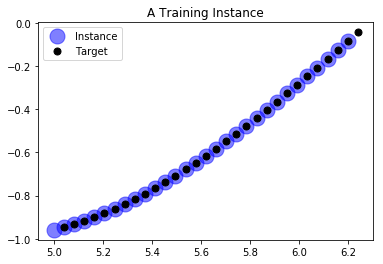

In [14]:
plt.title("A Training Instance")
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), "bo", markersize=15, 
         alpha=0.5, label="Instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko", markersize=7, label="Target")
plt.legend()

## Creating the Model

In [15]:
tf.reset_default_graph()

In [16]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.001
num_train_iterations = 2000
batch_size = 1

In [17]:
# Placeholders
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [18]:
# RNN Cell Layer
# cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu) before wrapping to 1 output
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu), 
                                output_size=num_outputs)


In [19]:
# RNN Cell Layer
# cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu) before wrapping to 1 output
# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu), 
#                                output_size=num_outputs)

In [20]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [21]:
# Loss - Mean squared error
loss = tf.reduce_mean(tf.square(outputs-y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [22]:
# Session
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    for iteration in range(num_train_iterations):
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y:y_batch})
            print(iteration, "\tMSE", mse)
            
    saver.save(sess, "./rnn_with_tf_code_from_Juan_GRU1")

0 	MSE 0.18939236
100 	MSE 0.04284181
200 	MSE 0.02599973
300 	MSE 0.0033311213
400 	MSE 0.020938043
500 	MSE 0.014990809
600 	MSE 0.009720615
700 	MSE 0.007045002
800 	MSE 0.0002058899
900 	MSE 0.004052845
1000 	MSE 0.0027779916
1100 	MSE 0.0005249405
1200 	MSE 0.00055251806
1300 	MSE 0.0022281802
1400 	MSE 0.00073047087
1500 	MSE 0.0007978442
1600 	MSE 5.8966867e-05
1700 	MSE 0.00025243787
1800 	MSE 0.00032985903
1900 	MSE 0.00022432262


In [23]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_with_tf_code_from_Juan_GRU1")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict = {X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_with_tf_code_from_Juan_GRU1


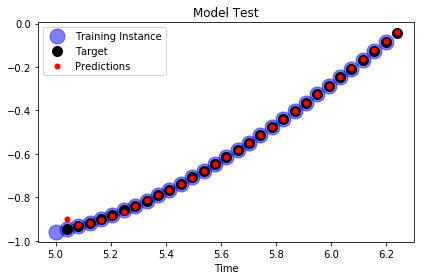

In [24]:
plt.title("Model Test")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15, alpha=0.5, label="Training Instance")

# Target to predict (Correct test values)
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="Target")

# Models prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="Predictions")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

## Generating a New Sequence

In [25]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_with_tf_code_from_Juan_GRU1")
    
    # Seed Zeros
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_with_tf_code_from_Juan_GRU1


Text(0,0.5,'Y')

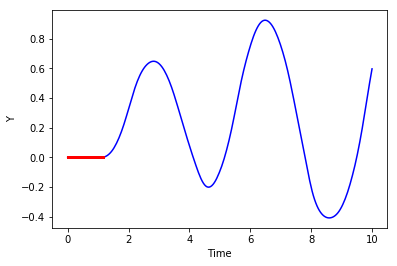

In [26]:
plt.plot(ts_data.x_data, zero_seq_seed, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Y")

In [27]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_with_tf_code_from_Juan_GRU1")
    
    # Seed Training Instance
    training_instance = list(ts_data.y_true[:30])
    
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        
        training_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_with_tf_code_from_Juan_GRU1


Text(0,0.5,'Y')

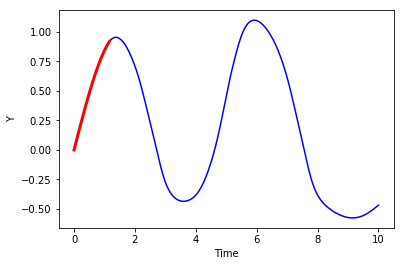

In [28]:
plt.plot(ts_data.x_data, training_instance, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], training_instance[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Y")